# Facial oils for acne-prone skin: Ingredients that differentiate high-rated products from low-rated products

I have built a model that takes the ingredients of a facial oil as input and decides if the facial oil is a high-rated product or not. I built this model using data on ingredients from 79 different facial oils targeting acne-prone skin. Using this model, I also identified the key ingredients that determine if a facial oil has a high rating or low rating. The criteria for a high rating was 4.5 or above, the maximum being 5.

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusion">Conclusion</a></li>
</ul>

<a id='intro'></a>
## Introduction
This dataset contains information about 79 facial oils for acne-prone skin. This data has been collected from influenster.com, including average consumer ratings and ingredients. (Source: https://www.influenster.com/)

I want to answer the following questions about this dataset:
<ul>
<li><a href="#q1"> 1. How do you decide if a new facial oil is a high-rated product?  </a></li>
    I'm going to answer this question by building a model, using ingredients data collected for existing products.
<li><a href="#q2"> 2. Which ingredients help determine if the product is high-rated?</a></li> The feature importance attribute of the model gives us the key features (ingredients).
</ul>

In an effort to keep the playing field fair, I have only included facial oils that have been rated on influenster.com.
The most surprising part of this case study was the realization that no clean data on the properties of facial oils exists and had to leverage my own skincare knowledge to filter the results. For example, when you query “facial oil, acne-prone skin,” even the most reliable search engines are unable to provide a clean list of facial oils for acne-prone skin. 

When ingredients were not provided on influenster.com, I used the direct manufacturer site to access a list of ingredients.

It took a lot of effort to generate clean data on ingredients. In order to make the list of ingredients comma separated, I had to first clean the data. I also had to standardize ingredient names for different products to common ingredient names, based on my skincare ingredients and chemistry knowledge.

In the following sections, you will notice that I deployed AdaBoostClassifier to accurately model facial oil ratings using data collected from Influenster. I had tried three models - RandomForestClassifier, AdaBoostClassifier, and Support Vector Machines, and AdaBoostClassifier gave me the best results. My goal was to construct a model that accurately predicts whether a facial oil could have a rating of more than 4.5 out of 5.0. Understanding a new facial oil's rating can help an individual decide if he or she should purchase it. In other words, it can be difficult to determine a new facial oil's genuine rating, as reviews from the general public are often qualitative and based on personal opinion and/or preferences. To that end, I used other publically available features of the facial oil, like ingredient composition, to provide a more accurate rating.

I trained the model on training data and verified how the model performs in testing data. The AdaBoostClassifier model performed better than Naive Classification (accepting all products to have a rating of 4.5 or higher) on the test data and the training data. I concluded that the AdaBoostClassifier model performed better because it displayed a higher accuracy and F-score. After having examined the key features used by this classifier model, I am confident that the output makes sense and that the model is working properly - I can say this based on my expertise in skincare.

<a id='wrangling'></a>
## Data Wrangling

In this section of the report, I load in the data, check for cleanliness, and then trim and clean the dataset for analysis.

Let's run the code cell below to load necessary Python libraries and data:

In [29]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals_analyze_study as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Facial_Oils_for_Acne_Prone_Skin dataset and print shape 
df = pd.read_csv('facial_oils_data.csv')
print(df.shape)

(79, 5)


### General Properties

In [32]:
# Display the first five lines.
display(df.head(n=5))

,Facial Oils for Acne Prone Skin,Price ($),Rating,#Reviews,Ingredients
0,Sunday Riley UFO Ultra-Clarifying Face Oil,40.00,4.3,3767,"Silybum Marianum (Milk Thistle) Seed Oil, Nige..."
1,Trilogy Certified Organic Rosehip Oil,29.00,4.6,109,Rosa Canina (Rosehip) Seed Oil
2,Herbivore Botanicals Lapis Facial Oil,72.00,4.4,947,"Squalane, Simmondsia Chinensis (Jojoba) Seed O..."
3,Burt's Bees Complete Nourishment Facial Oil,19.99,4.2,177,Rosa Canina Seed Extract (Rosehip Seed Extract...
4,Skinowl Maqui Berry Beauty Drops PM,85.00,5.0,2,Raw-Organic-cold-pressed African Adansonia dig...


In [33]:
# Performing operations to inspect data types and looking for instances of missing or possibly errant data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 5 columns):
Facial Oils for Acne Prone Skin    79 non-null object
Price ($)                          79 non-null float64
Rating                             79 non-null float64
#Reviews                           79 non-null int64
Ingredients                        79 non-null object
dtypes: float64(2), int64(1), object(2)
memory usage: 3.2+ KB


The data types for columns look practical and consistent.

###  Map ingredients to the same name
Ingredients for facial oils do not follow a standardized naming convention. Hence, many ingredients need to be mapped to common names. For example, 
1. Trilogy Certified Organic Rosehip Oil has ingredient "Rosa Canina (Rosehip) Seed Oil" -> I mapped "Rosa Canina (Rosehip) Seed Oil" to "Rosehip Oil". 
2. bareMinerals Mineralixirs 5-Oil Blend has ingredient "rosehip seed oil" -> I mapped "rosehip seed oil" to "Rosehip Oil".


In this way, I have generated a list of standardized names for ingredients. This has helped me reduce the 1037 different ingredient names to 356 ingredient names.

In [36]:
# Loading the ingredient map. This file contains the actual ingredient name in each product AND the common name to which it was mapped.
df_ingredient_map = pd.read_csv('facial_oils_ingredients_map.csv')
# view data
df_ingredient_map.head()

,Unnamed: 0,Actual_Ingredient,Map_Ingredient
0,0,*Golden Simmondsia Chinensis (Jojoba) Seed Oil,Jojoba Oil
1,1,100% Pure olive derived squalane.,Squalane
2,2,100% pure-unrefined-organic-cold-pressed Jojob...,Jojoba Oil
3,3,Anthyllis Vulneraria Extract,Anthyllis Vulneraria
4,4,Aqua,Distilled Water


In [38]:
# Create dictionary ingredient map, in which key is the actual ingredient name in each product AND the value is the common name to which it was mapped. 
ingredient_map = dict(zip(df_ingredient_map.Actual_Ingredient, df_ingredient_map.Map_Ingredient))

ingredient_map has values of this type:

 '100% Pure olive derived squalane.': 'Squalane',
 
 '100% pure-unrefined-organic-cold-pressed Jojoba Oil -\xa0Simmondsia Chinensis': 'Jojoba Seed Oil',
 
 'Anthyllis Vulneraria Extract': 'Anthyllis Vulneraria',
 
 'Aqua': 'Distilled Water',
 
 'Carthamus tinctorius (Safflower) Seed Oil': 'Safflower Seed Oil',

In [41]:
# Generate the clean list of ingredients using the mapped common names.
df = vs.generate_ingredients_clean(df, ingredient_map)

In [42]:
df.head()

,Facial Oils for Acne Prone Skin,Price ($),Rating,#Reviews,Ingredients,Ingredients_Clean
0,Sunday Riley UFO Ultra-Clarifying Face Oil,40.00,4.3,3767,"Silybum Marianum (Milk Thistle) Seed Oil, Nige...","Milk Thistle Seed Oil,Black Cumin Seed Oil,Cuc..."
1,Trilogy Certified Organic Rosehip Oil,29.00,4.6,109,Rosa Canina (Rosehip) Seed Oil,Rosehip Oil
2,Herbivore Botanicals Lapis Facial Oil,72.00,4.4,947,"Squalane, Simmondsia Chinensis (Jojoba) Seed O...","Squalane,Jojoba Oil,Fractionated Coconut Oil,K..."
3,Burt's Bees Complete Nourishment Facial Oil,19.99,4.2,177,Rosa Canina Seed Extract (Rosehip Seed Extract...,"Rosehip Oil,Jojoba Oil,Natural Fragrance,Eveni..."
4,Skinowl Maqui Berry Beauty Drops PM,85.00,5.0,2,Raw-Organic-cold-pressed African Adansonia dig...,"Baobab Oil,Maqui Berry Oil,Vanilla Extract,Tan..."


### Drop Rows with Missing Values

In [43]:
# dropping rows with any null values in dataset
df.dropna(inplace=True)

In [44]:
# checking if any of columns have null values - should print False
df.isnull().sum().any()

False

### Dedupe Data

In [45]:
# printing number of duplicates in dataset
print(df.duplicated().sum())

0


In [46]:
# printing number of duplicates again to confirm dedupe - should be 0
print(df.duplicated().sum())

0


<a id='eda'></a>
## Exploratory Data Analysis

The trimming and cleaning the data has been done. Now, I will explore and address the research questions that I posed in the Introduction. 

In [47]:
# Rating threshold to decide high- vs. low-rated facial oils
rating_threshold = 4.5
df.head()

,Facial Oils for Acne Prone Skin,Price ($),Rating,#Reviews,Ingredients,Ingredients_Clean
0,Sunday Riley UFO Ultra-Clarifying Face Oil,40.00,4.3,3767,"Silybum Marianum (Milk Thistle) Seed Oil, Nige...","Milk Thistle Seed Oil,Black Cumin Seed Oil,Cuc..."
1,Trilogy Certified Organic Rosehip Oil,29.00,4.6,109,Rosa Canina (Rosehip) Seed Oil,Rosehip Oil
2,Herbivore Botanicals Lapis Facial Oil,72.00,4.4,947,"Squalane, Simmondsia Chinensis (Jojoba) Seed O...","Squalane,Jojoba Oil,Fractionated Coconut Oil,K..."
3,Burt's Bees Complete Nourishment Facial Oil,19.99,4.2,177,Rosa Canina Seed Extract (Rosehip Seed Extract...,"Rosehip Oil,Jojoba Oil,Natural Fragrance,Eveni..."
4,Skinowl Maqui Berry Beauty Drops PM,85.00,5.0,2,Raw-Organic-cold-pressed African Adansonia dig...,"Baobab Oil,Maqui Berry Oil,Vanilla Extract,Tan..."


### Investigating the Questions

<a id='q1'></a>
### 1. How do you decide if a new facial oil is a high-rated product?
I answered this question by building a model, using ingredients data collected for existing products.

### Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with. However, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

In the Exploratory Data Analysis table above, you can see there are several ingredients for each facial oil and these are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (ingredients, in this case) be converted. To provide numeric inputs, you will see I created a column for each separate ingredient and assigned the value "1" for a facial oil that contains that ingredient and the value "0" for a facial oil that does not contain that ingredient. For example, if facial_oil_1 contains ingredient A, B and D but not C, facial_oil_1 will have feature values:

|Facial Oil Name|A|B|C|D|
|:---|:---|:---|:---|:---|
|facial_oil_1|1|1|0|1|

In [48]:
# create a column for each separate ingredient and assign the value "1" for a facial oil that contains that ingredient and the value "0" for a facial oil that does not contain that ingredient.
data = vs.generate_ingredient_columns(df) 

In [49]:
data.columns

Index(['Facial Oils for Acne Prone Skin', 'Price ($)', 'Rating', '#Reviews',
       'Ingredients', 'Ingredients_Clean', 'Milk Thistle Seed Oil',
       'Black Cumin Seed Oil', 'Cucumber Oil', 'Diisopropyl Sebacate',
       ...
       'Bitter Orange Flower Extract', 'Maracuja Oil',
       'Hamamelis Virginiana Leaf/Bark/Twig Extract', 'Dicaprylyl Ether',
       'Dicaprylyl Carbonate', 'Coriander Seed Oil', 'Ginger Root Oil',
       'Acerola Fruit Extract', 'Cetearyl Isononanoate', 'Isostearyl Alcohol'],
      dtype='object', length=362)

In [50]:
data.head()

,Facial Oils for Acne Prone Skin,Price ($),Rating,#Reviews,Ingredients,Ingredients_Clean,Milk Thistle Seed Oil,Black Cumin Seed Oil,Cucumber Oil,Diisopropyl Sebacate,...,Bitter Orange Flower Extract,Maracuja Oil,Hamamelis Virginiana Leaf/Bark/Twig Extract,Dicaprylyl Ether,Dicaprylyl Carbonate,Coriander Seed Oil,Ginger Root Oil,Acerola Fruit Extract,Cetearyl Isononanoate,Isostearyl Alcohol
0,Sunday Riley UFO Ultra-Clarifying Face Oil,40.00,4.3,3767,"Silybum Marianum (Milk Thistle) Seed Oil, Nige...","Milk Thistle Seed Oil,Black Cumin Seed Oil,Cuc...",1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,Trilogy Certified Organic Rosehip Oil,29.00,4.6,109,Rosa Canina (Rosehip) Seed Oil,Rosehip Oil,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Herbivore Botanicals Lapis Facial Oil,72.00,4.4,947,"Squalane, Simmondsia Chinensis (Jojoba) Seed O...","Squalane,Jojoba Oil,Fractionated Coconut Oil,K...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Burt's Bees Complete Nourishment Facial Oil,19.99,4.2,177,Rosa Canina Seed Extract (Rosehip Seed Extract...,"Rosehip Oil,Jojoba Oil,Natural Fragrance,Eveni...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Skinowl Maqui Berry Beauty Drops PM,85.00,5.0,2,Raw-Organic-cold-pressed African Adansonia dig...,"Baobab Oil,Maqui Berry Oil,Vanilla Extract,Tan...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
# Total number of records
n_records = data.shape[0]
analyze_var_threshold = rating_threshold
# Number of records where product's rating is more than 4.5
n_greater_45= data[data["Rating"] > analyze_var_threshold].shape[0]

# Number of records where product's rating is at most 4.5
n_at_most_45= data[data["Rating"] <= analyze_var_threshold].shape[0]

# Percentage of products whose rating is more than 4.5
greater_percent = 100*(float(n_greater_45 / n_records))

# Print the results
print("Total number of records: {}".format(n_records))
print("Facial oils with rating more than 4.5: {}".format(n_greater_45))
print("Facial oils with rating 4.5 or lower: {}".format(n_at_most_45))
print("Percentage of facial oils with rating more than 4.5: {}%".format(greater_percent))

Total number of records: 79
Facial oils with rating more than 4.5: 32
Facial oils with rating 4.5 or lower: 47
Percentage of facial oils with rating more than 4.5: 40.50632911392405%


#### Separate the features and ratings

In [54]:
# Split the data into features and target label
ratings_raw = data['Rating']
features_raw = data.drop('Rating', axis = 1)
features_raw = features_raw.drop('Facial Oils for Acne Prone Skin', axis = 1)
features_raw = features_raw.drop('Ingredients_Clean', axis = 1)
features_raw = features_raw.drop('Ingredients', axis = 1)
features_raw = features_raw.drop('Price ($)', axis = 1)
features_raw = features_raw.drop('#Reviews', axis = 1)

In [55]:
ratings_raw.head()

0    4.3
1    4.6
2    4.4
3    4.2
4    5.0
Name: Rating, dtype: float64

In [56]:
features_raw.head()

,Milk Thistle Seed Oil,Black Cumin Seed Oil,Cucumber Oil,Diisopropyl Sebacate,Pomegranate Seed Oil,Cranberry Seed Oil,Dimethyl Isosorbide,Flaxseed Oil,Capric Triglyceride,Ethyl Linoleate,...,Bitter Orange Flower Extract,Maracuja Oil,Hamamelis Virginiana Leaf/Bark/Twig Extract,Dicaprylyl Ether,Dicaprylyl Carbonate,Coriander Seed Oil,Ginger Root Oil,Acerola Fruit Extract,Cetearyl Isononanoate,Isostearyl Alcohol
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
features = pd.DataFrame(data = features_raw)
# Show an example of a record with scaling applied
display(features.head(n = 5))

,Milk Thistle Seed Oil,Black Cumin Seed Oil,Cucumber Oil,Diisopropyl Sebacate,Pomegranate Seed Oil,Cranberry Seed Oil,Dimethyl Isosorbide,Flaxseed Oil,Capric Triglyceride,Ethyl Linoleate,...,Bitter Orange Flower Extract,Maracuja Oil,Hamamelis Virginiana Leaf/Bark/Twig Extract,Dicaprylyl Ether,Dicaprylyl Carbonate,Coriander Seed Oil,Ginger Root Oil,Acerola Fruit Extract,Cetearyl Isononanoate,Isostearyl Alcohol
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Convert the target label `'rating_raw'` to numerical entries.
   - Set records with <=4.5 to `0` and records with >4.5 to `1`.

In [67]:
# Encode the 'ratings_raw' data to numerical values
ratings = ratings_raw > rating_threshold

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# print in the following line shows the encoded feature names
print(encoded)

356 total features after one-hot encoding.
['Milk Thistle Seed Oil', 'Black Cumin Seed Oil', 'Cucumber Oil', 'Diisopropyl Sebacate', 'Pomegranate Seed Oil', 'Cranberry Seed Oil', 'Dimethyl Isosorbide', 'Flaxseed Oil', 'Capric Triglyceride', 'Ethyl Linoleate', 'Hexylresorcinol', 'Licorice', 'Salicylic Acid', 'Apricot Kernel Oil', 'Matricaria Flower Extract', 'Neroli Flower Extract', 'Tea Tree Oil', 'Sunflower Oil', 'Rosemary Extract', 'Grapefruit Peel Oil', 'Neem Leaf Extract', 'Neem Flower Extract', 'Ivy Gourd Fruit Extract', 'Amino Esters-1', 'Amber Leaf Extract', 'Eggplant Fruit Extract', 'Aloe Vera Flower Extract', 'Henna Extract', 'Tulsi Leaf Extract', 'Basil Extract', 'Turmeric Root Extract', 'Corallina Officinalis Extract', 'Jojoba Oil', 'Pearl Powder', 'Moringa Seed Oil', 'Rosehip Oil', 'Squalane', 'Fractionated Coconut Oil', 'Kukui Nut Oil', 'Tocopherol', 'Blue Tansy Leaf Oil', 'Jasmine', 'Moroccan Rose Absolute', 'Natural Fragrance', 'Evening Primrose Seed Extract', 'Borage Oi

In [59]:
data.columns

Index(['Facial Oils for Acne Prone Skin', 'Price ($)', 'Rating', '#Reviews',
       'Ingredients', 'Ingredients_Clean', 'Milk Thistle Seed Oil',
       'Black Cumin Seed Oil', 'Cucumber Oil', 'Diisopropyl Sebacate',
       ...
       'Bitter Orange Flower Extract', 'Maracuja Oil',
       'Hamamelis Virginiana Leaf/Bark/Twig Extract', 'Dicaprylyl Ether',
       'Dicaprylyl Carbonate', 'Coriander Seed Oil', 'Ginger Root Oil',
       'Acerola Fruit Extract', 'Cetearyl Isononanoate', 'Isostearyl Alcohol'],
      dtype='object', length=362)

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. I have split the data (both features and their labels) into training and test sets. Given that the data has less number of facial oils and I want to have a good number of points for testing as well, I have split the data into similar proportions for training and testing. 55% of the data will be used for training and 45% for testing.

Run the code cell below to perform this split.

In [60]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'rating' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    ratings, 
                                                    test_size = 0.45, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 43 samples.
Testing set has 36 samples.


In [61]:
features.columns

Index(['Milk Thistle Seed Oil', 'Black Cumin Seed Oil', 'Cucumber Oil',
       'Diisopropyl Sebacate', 'Pomegranate Seed Oil', 'Cranberry Seed Oil',
       'Dimethyl Isosorbide', 'Flaxseed Oil', 'Capric Triglyceride',
       'Ethyl Linoleate',
       ...
       'Bitter Orange Flower Extract', 'Maracuja Oil',
       'Hamamelis Virginiana Leaf/Bark/Twig Extract', 'Dicaprylyl Ether',
       'Dicaprylyl Carbonate', 'Coriander Seed Oil', 'Ginger Root Oil',
       'Acerola Fruit Extract', 'Cetearyl Isononanoate', 'Isostearyl Alcohol'],
      dtype='object', length=356)

----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of my choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
I will use **F-beta score** as the metric to decide how effective a model is:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$


F1 score is the weighted average (harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score.

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

I expect my model to have a higher F-score than the Naive Predictor. Naive Predictor classifies every facial oil to have a rating of more than 4.5.

### Naive Predictor Performace
If I chose a model that always predicted a facial oil to have a rating of > 4.5, what would that model's accuracy and F-score be on this dataset? 

In [68]:
TP = np.sum(ratings) # Counting the "1"s as this is the naive case. Note that 'rating' is the 'rating_raw' data encoded to numerical values done in the data preprocessing step.
FP = ratings.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = float(TP + TN)/(TP + FP + TN + FN)
recall = float(TP)/(TP+FN)
precision = float(TP)/(TP+FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1 + beta**2) * (precision*recall) / (beta**2*precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.4051, F-score: 0.4598]


###  Supervised Learning Models
**I am going to explore using these 3 models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html):

AdaBoostClassifier

RandomForestClassifier

Support Vector Machines

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model I've chosen, it's important that I create a training and predicting pipeline that allows me to quickly and effectively train models using training data and perform predictions on the testing data. In evaluate_models function, I will do the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.

### Implementation: Model Evaluation

RandomForestClassifier trained on 43 samples.
ModelName: RandomForestClassifier, F-score: 0.42372881355932196, Accuracy: 0.5555555555555556, train_time: 0.043883562088012695, pred_time: 0.005984783172607422, samples: 43
RandomForestClassifier trained on 43 samples.
ModelName: RandomForestClassifier, F-score: 0.42372881355932196, Accuracy: 0.5555555555555556, train_time: 0.03241300582885742, pred_time: 0.0024552345275878906, samples: 43
RandomForestClassifier trained on 43 samples.
ModelName: RandomForestClassifier, F-score: 0.42372881355932196, Accuracy: 0.5555555555555556, train_time: 0.023935556411743164, pred_time: 0.003988981246948242, samples: 43
AdaBoostClassifier trained on 43 samples.
ModelName: AdaBoostClassifier, F-score: 0.514018691588785, Accuracy: 0.5555555555555556, train_time: 1.0472614765167236, pred_time: 0.14299678802490234, samples: 43
AdaBoostClassifier trained on 43 samples.
ModelName: AdaBoostClassifier, F-score: 0.514018691588785, Accuracy: 0.5555555555555556, tr

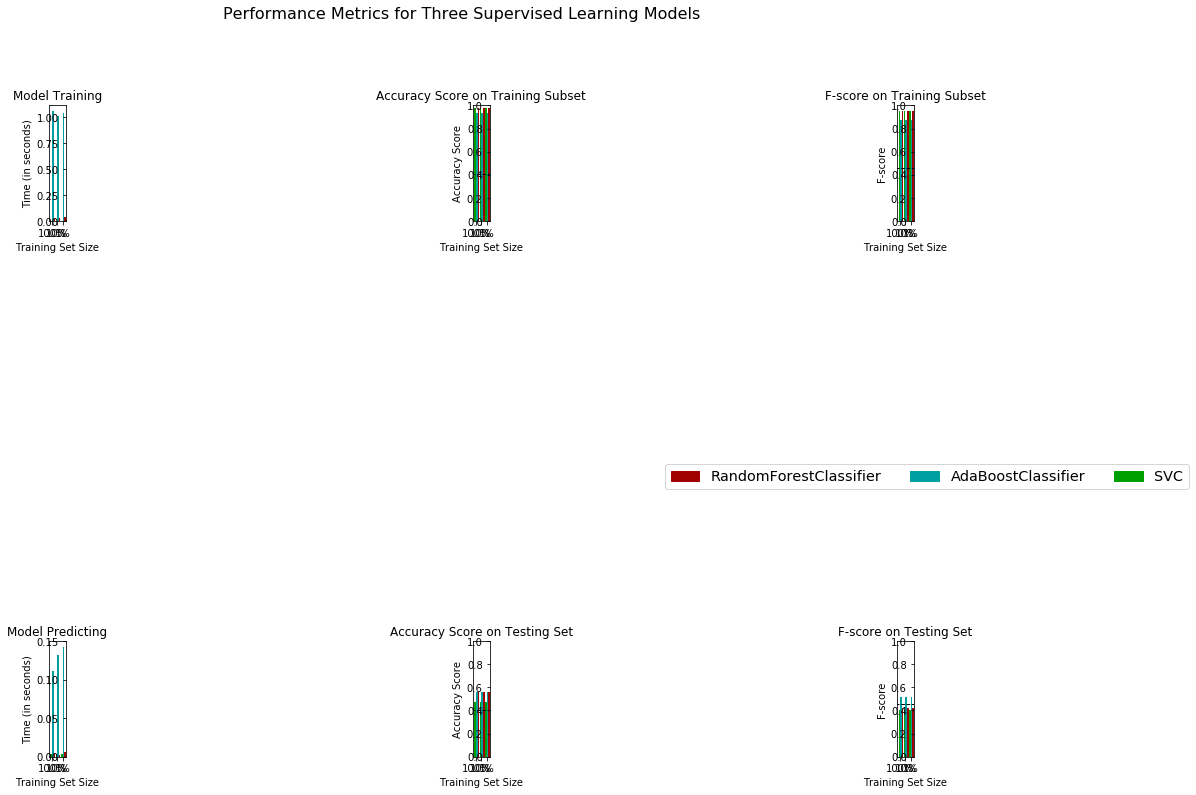

In [64]:
# Import the three supervised learning models from sklearn
results = vs.evaluate_models(X_train, y_train, X_test, y_test)
vs.evaluate(results, accuracy, fscore)

### Choosing the Best Model

Based on the evaluation I performed earlier, I describe below which of the three models I believe to be most appropriate for identifying facial oils that have rating > 4.5. 



Based on the F-score for testing set, AdaBoostClassifier has the highest F-score and accuracy. These are the F-score and accuracy values for the AdaBoost model vs. Naive Predictor for the testing set when 100% of the training set is used:

|     Metric     | Naive Predictor   | AdaBoostClassifier|
| :------------: | :---------------: | :---------------: | 
| Accuracy Score |      0.4051       |       0.5555      |
| F-score        |      0.4598       |       0.5140      |

F-score and accuracy are reliable metrics to decide how effective a model is and hence, I can confidently say the AdaBoostClassifier is the best method. Hence, AdaBoostClassifier has done a better job at predicting if a facial oil could have a rating > 4.5.

### Describing the Model in Layman's Terms

I explain below, in layman's terms, how the final model chosen is supposed to work. I describe the major qualities of the model, such as how the model is trained and how the model makes a prediction.

**Answer:** 

I have selected AdaBoostClassifier model. Here is the idea behind this model:
1. Fit the first learner to maximize accuracy or equivalently minimize the number of errors. Remember this model for later.

2. Now, use the second learner to fix the mistakes that the first model has made: Take the misclassified points of the first learner and make them bigger. In other words, punish the model more if it misses these points: This second weak learner needs to focus on these points more. Second weak learner will be this one, which correctly classifies these points. Remember this model also for later. 

3. Now again punish the points misclassified by the second model by enlarging these misclassified points. Third weak learner is this one which tries really hard to correctly classify the big points. Remember this model as well. 

4. Now combine these three models: First learner (Point 1. above), second learner (Point 2. above), third learner (Point 3. above)

5. The combination of these three models gives the AdaBoostClassifier model.



**References**: Udacity Lectures

<a id='q2'></a>
## 2. Which ingredients help determine if the product is highly rated?
The feature importance attribute of the model gives us the key features (ingredients).

An important task when performing supervised learning on a dataset like the facial data is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the rating, we simplify our understanding of the phenomenon. In this case study, that means I wish to identify a small number of features that most strongly predict whether a facial oil could have a rating of more than 4.5.

### Feature Relevance Observation
It was shown earlier that there are 356 different ingredients in the facial oils data. Out of these 356 ingredients, which ten ingredients do I believe to be most important for prediction, and in what order would I rank them?

### Implementation - Extracting Feature Importance

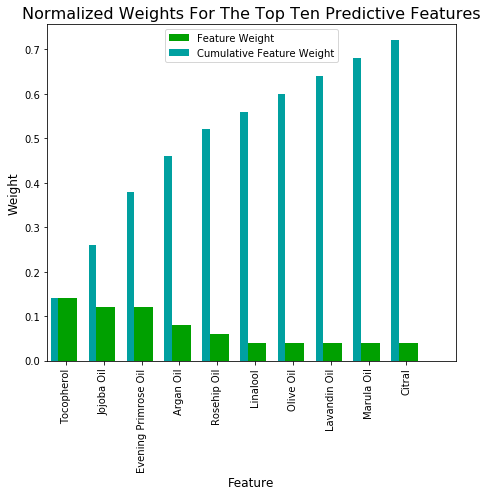

In [65]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(random_state = 100)

# Train the supervised model on the training set using .fit(X_train, y_train)
model = clf.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = clf.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

AdaBoostClassifier is a non-linear model, so I can only say that these are the key ingredients that the model looks for when determining the rating. I cannot say directly if the presence of an ingredient can have a linear relationship with the rating. However, from my experience and having tested several models, I can say:


<font color='green'>1. **Tocopherol**: Presence of Tocopherol as an ingredient should generally have a positive relationship with the rating of the facial oil being greater than 4.5</font>

<font color='green'>2. **Jojoba Oil**: Presence of Jojoba Oil as an ingredient should generally have a positive relationship with the rating of the facial oil being greater than 4.5</font>

<font color='green'>3. **Evening Primrose Oil**: Presence of Evening Primrose Oil as an ingredient should generally have a positive relationship with the rating of the facial oil being greater than 4.5</font>

<font color='green'>4. **Argan Oil**: Presence of Argan Oil as an ingredient should generally have a positive relationship with the rating of the facial oil being greater than 4.5</font>

<font color='green'>5. **Rosehip Oil**: Presence of Rosehip Oil as an ingredient should generally have a positive relationship with the rating of the facial oil being greater than 4.5</font>

<font color='green'>6. **Linalool**: Presence of Linalool as an ingredient should generally have a positive relationship with the rating of the facial oil being greater than 4.5</font>

<font color='green'>7. **Olive Oil**: Presence of Olive Oil as an ingredient should generally have a positive relationship with the rating of the facial oil being greater than 4.5</font>

<font color='red'>8. **Lavandin Oil**: Presence of Lavandin Oil as an ingredient should generally have a negative relationship with the rating of the facial oil being greater than 4.5</font>

<font color='green'>9. **Marula Oil**: Presence of Marula Oil as an ingredient should generally have a positive relationship with the rating of the facial oil being greater than 4.5</font>

<font color='green'>10. **Citral**: Presence of Citral as an ingredient should generally have a positive relationship with the rating of the facial oil being greater than 4.5</font>

<a id='conclusion'></a>
## Conclusion

I answered the following questions about this dataset:
1. How do you decide if a new facial oil is a high-rated product?

> I built a model that that takes in ingredients of the facial oil as input and outputs if the product could have a rating > 4.5/5.0. 
Due to over-the-top marketing campaigns, consumers are led to believe that most products have a high rating. However, I have proven that there is a data-driven alternative to falling into that trap: Given the ingredients of any facial oil (old or new to the market), my predictive model is a much more accurate indicator of whether or not that product is actually worthy of such high ratings and praise. 

|     Metric     | Naive Predictor   | My Model          |
| :------------: | :---------------: | :---------------: | 
| Accuracy Score |      0.4051       |       0.5555      |
| F-score        |      0.4598       |       0.5140      |


I built my model using the 356 different ingredients found in these 79 facial oils. I actually started with a total of 1037 ingredients, and, leveraging my expertise in skincare ingredients/chemistry, I was able to compress the total number of ingredients to 356. Because I succeeded in reducing the number of ingredients, I was able to increase the predictive power of the model.
As a skincare consumer, if you are driven by marketing schemes to accept any facial oil as a high-rated product, you will be correct 40% of the time. If you use my predictive model, you will be correct 55% of the time.



2. Which ingredients help determine if the product is highly rated?
The feature importance attribute of the model showed me the game-changing ingredients that could lead to a high rating.

> These ingredients are the key features that determine if a facial oil could have a high rating:

- Tocopherol
- Jojoba Oil
- Evening Primrose Oil
- Argan Oil
- Rosehip Oil
- Linalool
- Olive Oil
- Lavandin Oil
- Marula Oil
- Citral

Lavandin Oil is an exception among this group of game-changing oils - it can be a strong indicator of lower ratings (<= 4.5), whereas the others can be a strong indicator of higher ratings (> 4.5).

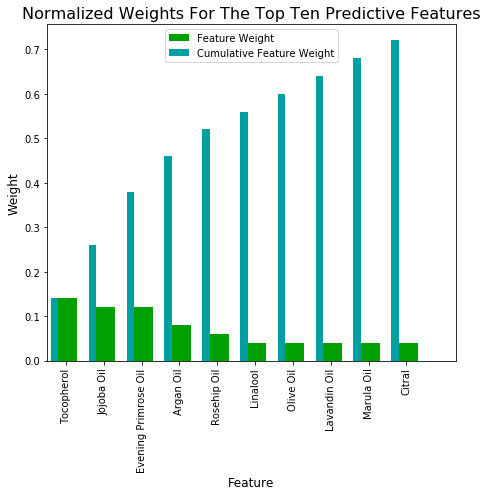